In [1]:
import os

path = os.getcwd()
folder_list = ['1_cut']
img_list = os.listdir(os.path.join(path, '1_cut'))
print(img_list)

path = os.getcwd()
folder_list = ['1-annot']
anot_list = os.listdir(os.path.join(path, '1-annot'))
print(anot_list)

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6-1.jpg', '6.jpg']
['1.json', '2.json', '3.json', '4.json', '5.json', '6-1.json', '6.json']


In [2]:
import json

for anot in anot_list:
    label_list = []
    point_list = []
    type_list = []

    with open('./1-annot/'+anot) as json_file:
        json_data = json.load(json_file)
    
        shapes = json_data['shapes']
    
        for shape in shapes:
            label = shape['label']
            label_list.append(label)
            point = shape['points']
            point_list.append(point)
            type = shape['shape_type']
            type_list.append(type)
        
    print('<', anot, '>')
    print(label_list)
    print(point_list)
    print(type_list)

< 1.json >
['void', 'solder']
[[[70.2, 56.4], [68.9, 57.5], [69.5, 61.6], [71.0, 63.1], [74.7, 62.0], [75.8, 59.1], [74.0, 57.3], [71.2, 56.0]], [[8.435897435897434, 71.97435897435898], [12.923076923076923, 76.46153846153845], [23.179487179487175, 76.78205128205127], [78.3076923076923, 79.34615384615384], [121.25641025641025, 87.03846153846155], [138.56410256410257, 88.64102564102564], [152.66666666666666, 88.32051282051282], [171.89743589743588, 77.10256410256409], [174.14102564102564, 65.56410256410255], [172.2179487179487, 51.46153846153845], [161.0, 45.37179487179486], [142.4102564102564, 38.96153846153845], [124.14102564102564, 37.03846153846153], [77.34615384615384, 40.88461538461539], [16.128205128205128, 41.84615384615384], [11.0, 43.76923076923076], [6.19230769230769, 47.93589743589743], [5.23076923076923, 66.84615384615384]]]
['polygon', 'polygon']
< 2.json >
['void', 'void', 'void', 'solder']
[[[86.9, 45.7], [85.2, 47.7], [85.9, 49.1], [88.4, 50.5], [90.2, 49.8], [90.3, 46.2

In [3]:
import imgaug as ia
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

image = cv2.imread('./1_cut/6.jpg')

### 각 클래스의 꼭지점 좌표 추출

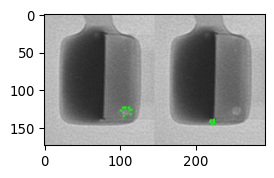

In [4]:
import numpy as np
from imgaug.augmentables.kps import KeypointsOnImage

kp_void = KeypointsOnImage.from_xy_array(point_list[0], shape=image.shape)
kp_solder = KeypointsOnImage.from_xy_array(point_list[1], shape=image.shape)

ia.imshow(np.hstack([kp_void.draw_on_image(image, size=2),
                    kp_solder.draw_on_image(image, size=2)]))

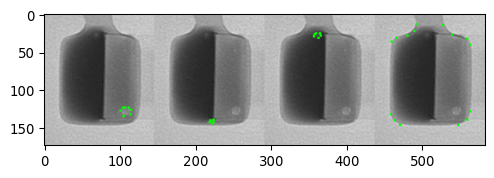

In [5]:
import numpy as np
from imgaug.augmentables.kps import KeypointsOnImage

void_list = []
solder_list = []
for i in range(len(type_list)):
    if label_list[i] == 'void':
        void_list.append(point_list[i])
    else:
        solder_list.append(point_list[i])
        
kp_list = []       
for i in range(len(void_list)):
    kp_void = KeypointsOnImage.from_xy_array(void_list[i], shape=image.shape)
    kp_list.append(kp_void)
    
kp_solder = KeypointsOnImage.from_xy_array(solder_list[0], shape=image.shape)
kp_list.append(kp_solder)

ia.imshow(np.hstack([i.draw_on_image(image, size=2) for i in kp_list]))

## 각 꼭지점을 연결해 polygon instance로 변환

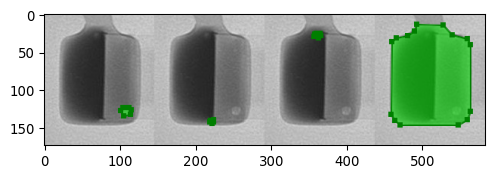

In [6]:
from imgaug.augmentables.polys import Polygon

poly_list = []
for kp in kp_list:
    poly = Polygon(kp.keypoints)
    poly_list.append(poly)

ia.imshow(np.hstack([i.draw_on_image(image, size=2) for i in poly_list]))

## 두 polygon을 하나의 segmentation map으로 변환

In [7]:
# 채널 3개 생성 (배경, void, solder)
segmap = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

# void polygon을 2번 채널에 넣기
for i in range(len(poly_list)-1):
    segmap = poly_list[i].draw_on_image(segmap,
                                    color=(0,255,0),
                                    alpha=1.0, alpha_lines=0.0, alpha_points=0.0)

# solder polygon을 3번 채널에 넣기
segmap = poly_list[-1].draw_on_image(segmap,
                                color=(0,0,255),
                                alpha=0.5, alpha_lines=0.0, alpha_points=0.0)

# 3채널 합치기
print(segmap.shape)
segmap = np.argmax(segmap, axis=2)
print(segmap.shape)

# int64 -> int32 : segmentationmapsonImage 의 maximum이 int32
segmap = segmap.astype(np.int32)

print("shape:",segmap.shape, "  ||   min value:", segmap.min(), "  ||   max value:", segmap.max())

(173, 146, 3)
(173, 146)
shape: (173, 146)   ||   min value: 0   ||   max value: 2


## 생성한 segmap을 imgaug의 
## SegmentationMapsOnImage 클래스의 객체로 변환

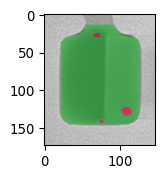

In [8]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

segmap = SegmentationMapsOnImage(segmap, shape=image.shape)
ia.imshow(segmap.draw_on_image(image)[0])

## Segmentation map을 Augment 하기

In [9]:
# augmentation할 sequence 생성

import imgaug.augmenters as iaa
ia.seed(2)

seq = iaa.Sequential([
    iaa.CoarseDropout(0.1, size_percent=0.2),
    iaa.Affine(rotate=(-30, 30)),
    iaa.ElasticTransformation(alpha=10, sigma=1)
], random_order=True)

# augmentation 파이프라인(seq) 를
## segmentation map과 image에 적용

In [10]:
import imageio

images_aug = []
segmaps_aug = []


for _ in range(5):
    image_aug_i, segmap_aug_i = seq(image=image, segmentation_maps=segmap)
    images_aug.append(image_aug_i)
    segmaps_aug.append(segmap_aug_i)
    # (1) 원래 이미지
    # (2) segmap + 원래 이미지
    # (3) augmented 이미지
    # (4) augmented 이미지 위에 augmented segmap
    # (5) augmeted segmap 만

"""# 시각화
ia.imshow(np.hstack([
    segmap_aug.draw_on_image(image_aug)[0], # image와 segmentation map을 같이 보여줌
    segmap_aug.draw()[0] # segmentation map만 보여줌
]))"""

cells = []

for image_aug, segmap_aug in zip(images_aug, segmaps_aug):
    cells.append(image)                                         # column 1
    cells.append(segmap.draw_on_image(image)[0])                # column 2
    cells.append(image_aug)                                     # column 3
    cells.append(segmap_aug.draw_on_image(image_aug)[0])        # column 4
    cells.append(segmap_aug.draw(size=image_aug.shape[:2])[0])  # column 5
    
grid_image = ia.draw_grid(cells, cols=5)
imageio.imwrite("example_segmaps.jpg", grid_image)

In [11]:
segmap_big = segmap.resize(3.0)
print("before:",segmap.arr.shape, " after:",segmap_big.arr.shape)

before: (173, 146, 1)  after: (519, 438, 1)


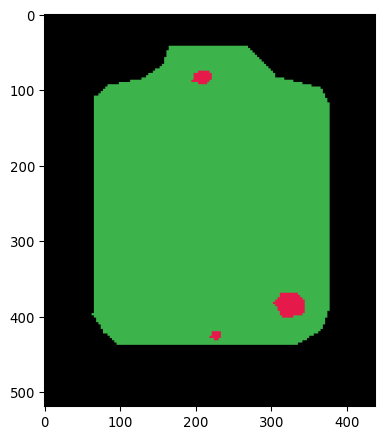

In [12]:
ia.imshow(segmap_big.draw()[0])